#DBSCAN

# Wine Quality Analysis and Prediction

## 1. Introduction & Purpose

### Problem Statement
The goal of this analysis is to understand and predict **wine quality** using physicochemical attributes.  
We will explore both **unsupervised** and **supervised** learning methods to uncover patterns and build predictive models.

### Dataset Information
- Dataset: Red wine quality dataset (`Wine_clean.csv`)  
- Target variable: `quality`  
- Features: Chemical properties

### Objectives
1. Clustering: Discover natural groupings among wines.  
2. Regression: Predict numeric quality scores.  
3. Classification: Classify wines into good vs not good.

### PCA (Principal Component Analysis)

#### What is PCA?
Principal Component Analysis (PCA) is a dimensionality reduction technique used to project high-dimensional data into a lower-dimensional space while preserving as much of the variance (information) as possible.

It helps:
- Remove redundancy caused by correlated features.  
- Speed up algorithms like t-SNE and DBSCAN.  
- Improve visualization by compressing data into 2D or 3D components.

---

#### How PCA Works

1. Standardize the dataset (zero mean, unit variance).  
2. Compute the covariance matrix $( \Sigma )$:  
   $$\Sigma = \frac{1}{n - 1} X^\top X$$
   where $( X )$ is the standardized data matrix.

3. Compute the eigenvalues $(( \lambda_i ))$ and eigenvectors $( v_i $) of $ (\Sigma )$:  
   $$\Sigma v_i = \lambda_i v_i$$
   Each eigenvector represents a principal component direction, and each eigenvalue indicates the variance explained by that component.

4. Sort eigenvectors by descending eigenvalues — higher $( lambda_i )$ → more variance explained.

5. Project data onto the top $( k )$ principal components:  
   $$Z = X W_k$$
   where $( W_k )$ contains the first $( k )$ eigenvectors (columns) and $( Z )$ is the transformed data in $( k )$-dimensional space.

---

#### Intuition

PCA finds new orthogonal axes (principal components) that capture the directions of maximum variance in the data.

- PC1 = direction of maximum variance  
- PC2 = direction orthogonal to PC1 with next-highest variance  
- and so on...


Importing Required Libraries

In [ ]:
# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import necessary libraries
import string
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_context('notebook')
sns.set_style('white')

# Import matplotlib for 3D plotting
import matplotlib.pyplot as plt

## 2. Data Preparation

### Load & Inspect Data

### Feature Preparation

In [ ]:
#Load the dataset:

path = 'Data/Wine_clean.csv'
df = pd.read_csv(path)
# Remove the unwanted "Unnamed: 0" column if it exists
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print("Dataset shape:", df.shape)
df.head(n=6)

Dataset shape: (1194, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,0.952872,0.142508,-0.938945,0.411596,-0.579638,5
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,0.454289,0.267217,-0.484660,0.153303,-0.579638,5
3,2.076938,-1.472812,1.731370,-0.646558,-0.243268,0.226211,0.684404,0.890766,-1.241802,-0.449381,-0.579638,6
4,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
5,-0.524869,0.832870,-1.377452,-0.872815,-0.243268,-0.227541,-0.082648,0.766056,1.408196,-0.621576,-0.989805,5


In [ ]:
# 1. Basic dataset overview

print("Dataset info:")
# Displays column types, non-null counts, memory usage
print(df.info())

print("\nSummary statistics:")
# Displays count, mean, std, min, 25%, 50%, 75%, max for each numeric column
print(df.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1194 non-null   float64
 1   volatile acidity      1194 non-null   float64
 2   citric acid           1194 non-null   float64
 3   residual sugar        1194 non-null   float64
 4   chlorides             1194 non-null   float64
 5   free sulfur dioxide   1194 non-null   float64
 6   total sulfur dioxide  1194 non-null   float64
 7   density               1194 non-null   float64
 8   pH                    1194 non-null   float64
 9   sulphates             1194 non-null   float64
 10  alcohol               1194 non-null   float64
 11  quality               1194 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 112.1 KB
None

Summary statistics:
       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.1940

The dataset has 1194 samples and 12 features (11 numeric + 1 categorical “quality”).

No missing values detected.

Outliers exist but not extreme.

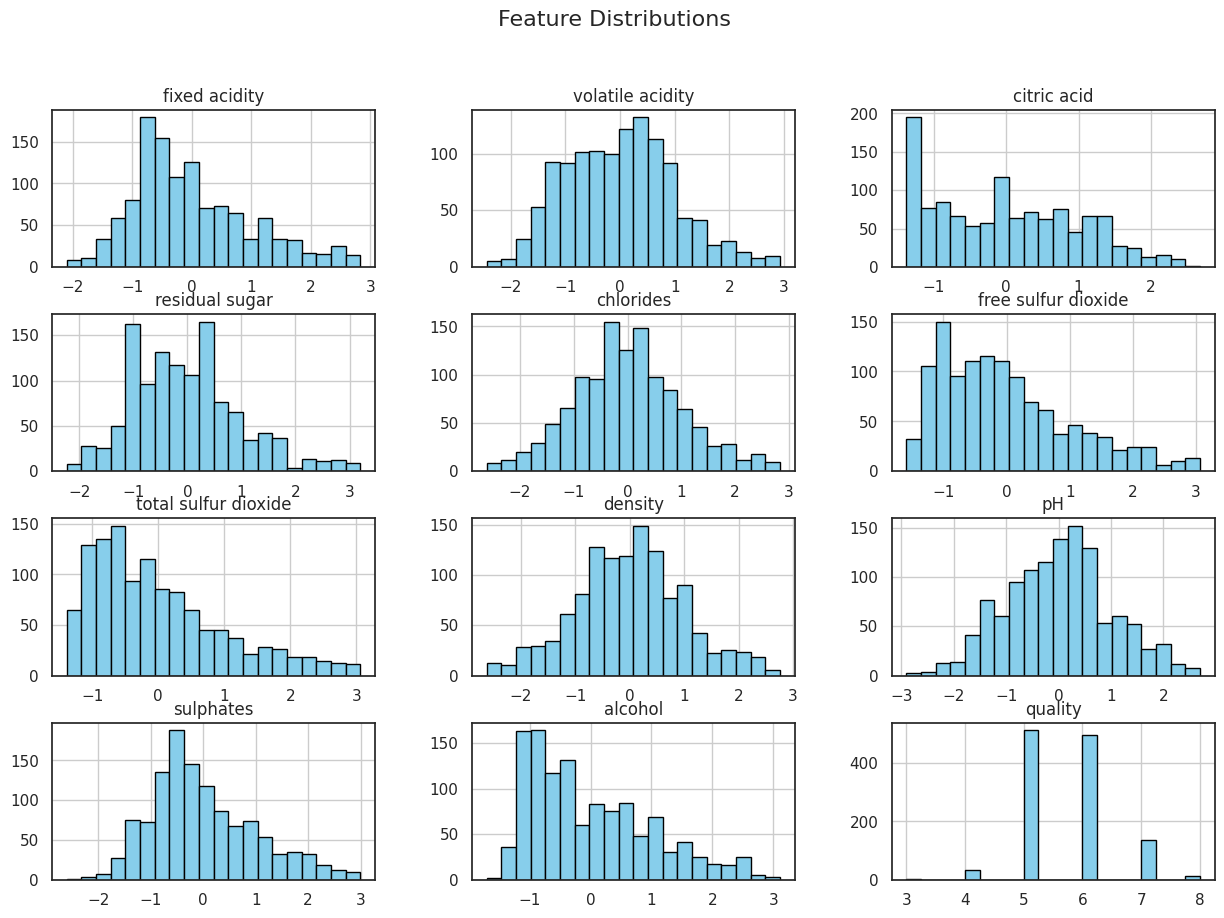

In [ ]:
# 2. Histograms for each feature

# Visualize the distribution of each feature to understand skew, spread, and potential outliers
df.hist(bins=20, figsize=(15,10), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

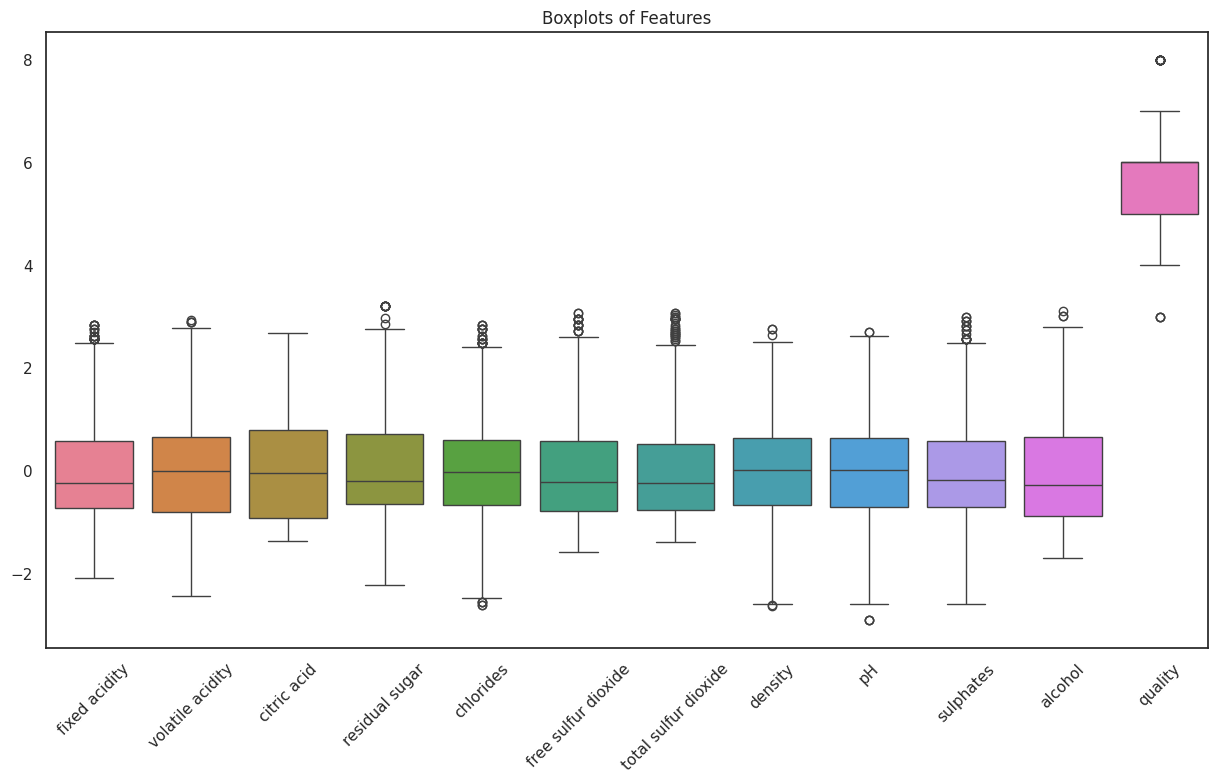

In [ ]:
# 3. Boxplots to detect outliers

# Boxplots help identify extreme values that could affect clustering
plt.figure(figsize=(15,8))
sns.boxplot(data=df.drop('Cluster', axis=1, errors='ignore'))  # Drop 'Cluster' column if it exists
plt.title("Boxplots of Features")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


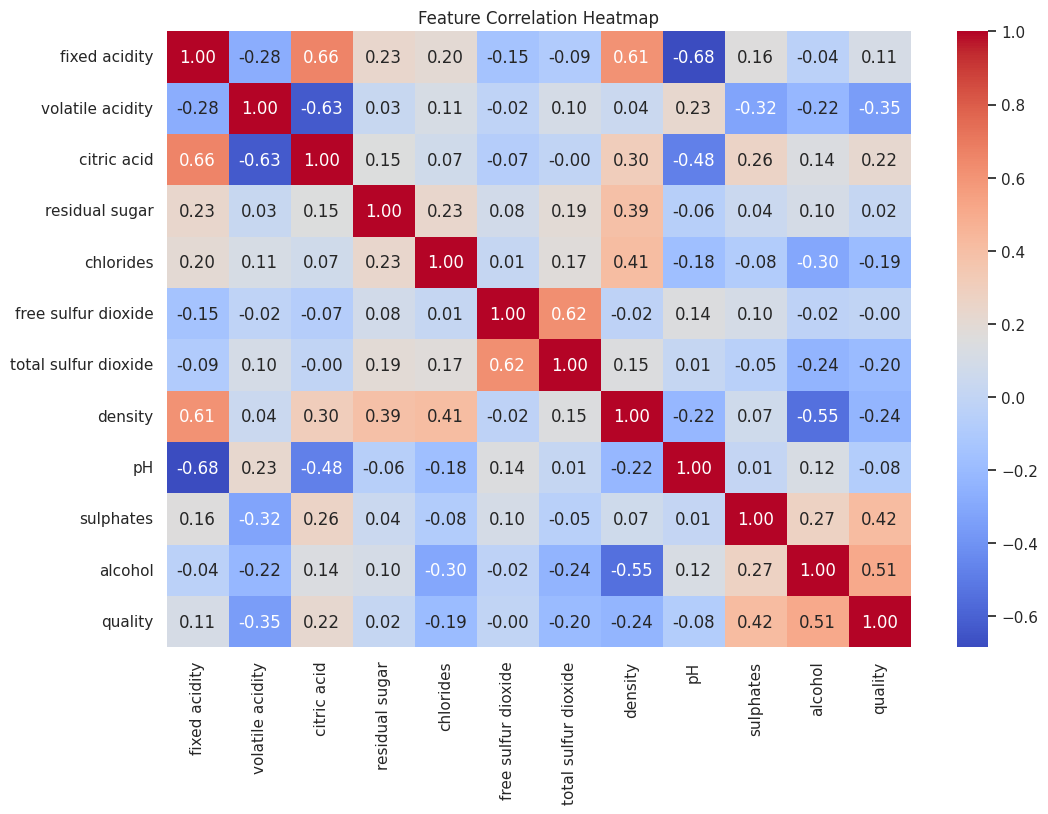

In [ ]:
# 4. Correlation matrix & heatmap

# Correlation shows how features relate to each other; useful for PCA and feature selection
corr = df.drop('Cluster', axis=1, errors='ignore').corr()  # Compute correlation of numeric features only
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)  # Annotate values on heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

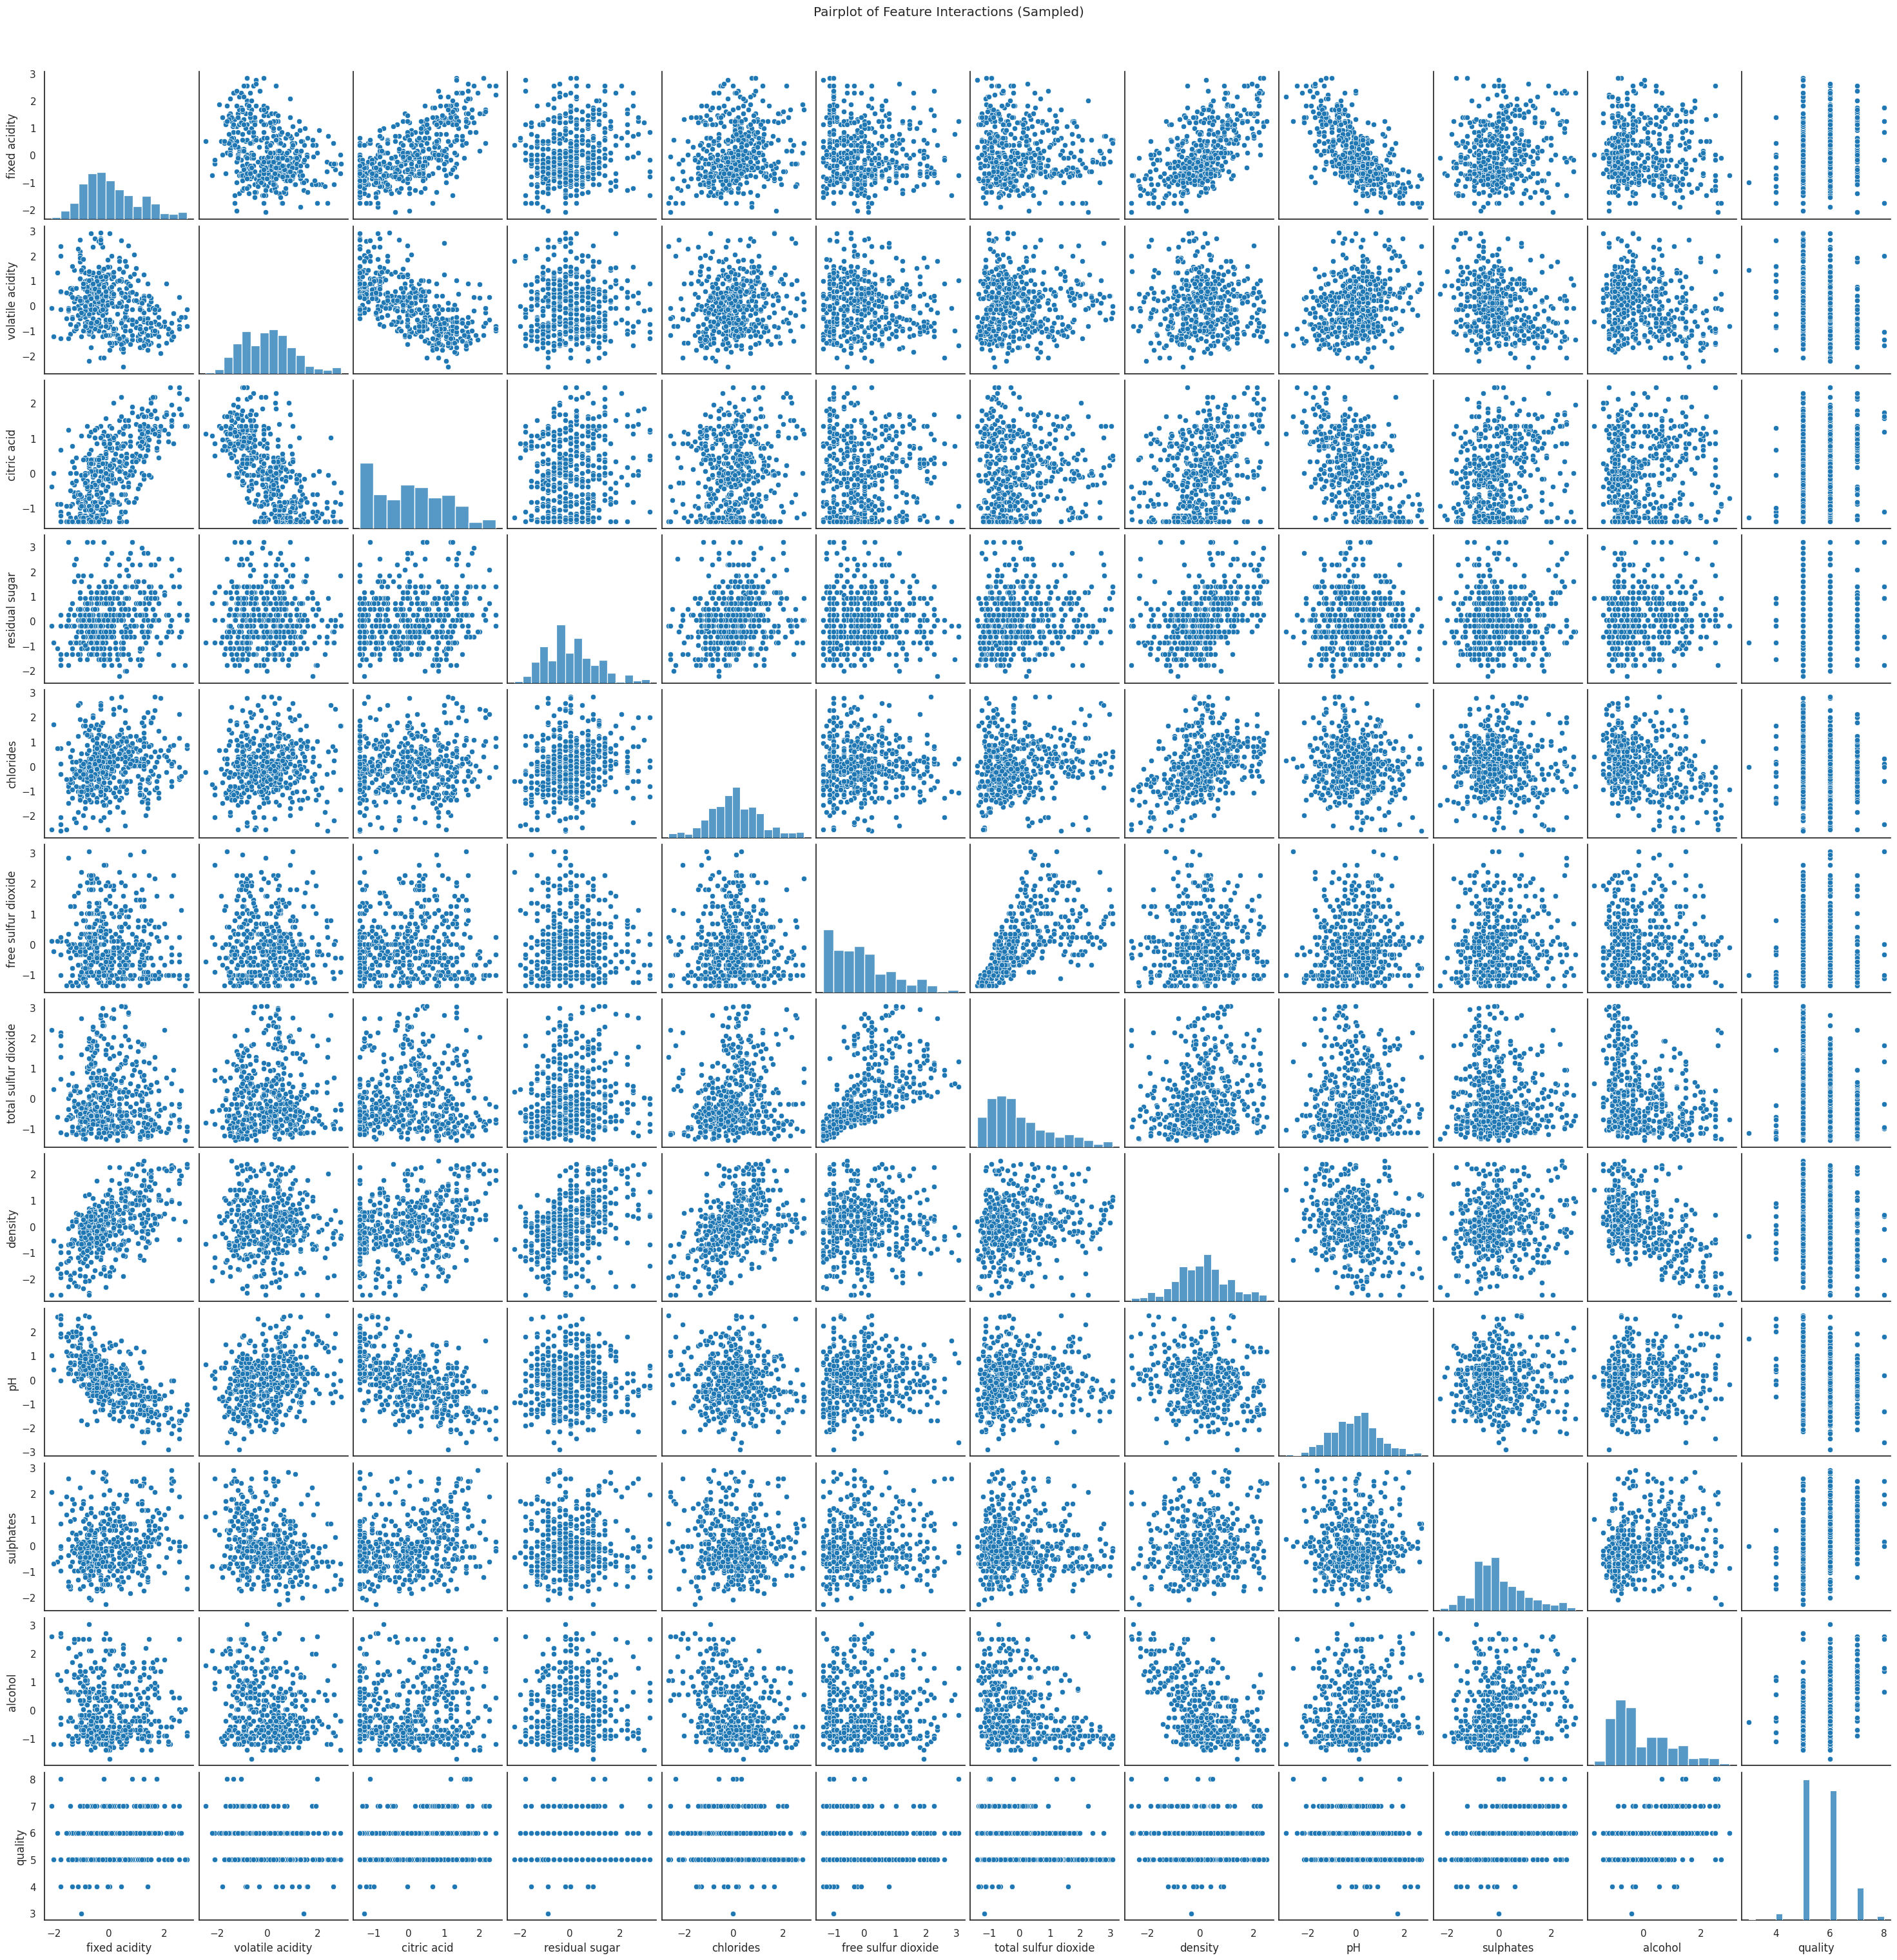

In [ ]:
# 5. Pairplot / scatter matrix (optional for large datasets)

# Visualize feature interactions. For large datasets, we sample to avoid overplotting.
sample_df = df.drop('Cluster', axis=1, errors='ignore').sample(n=min(500, len(df)), random_state=42)
sns.pairplot(sample_df)
plt.suptitle("Pairplot of Feature Interactions (Sampled)", y=1.02)  # Adjust title placement
plt.show()

## 3. Clustering

### t-SNE + DBSCAN Clustering


### Cluster–Quality Analysis


### Cluster Evaluation

###Explore the natural groupings (clusters) in the red wine dataset without using the “quality” label directly, and visualize them in 2D using t-SNE and DBSCAN.

In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

# --- Prepare features and labels ---
X = df.drop('quality', axis=1)
y = df['quality']

# --- Apply t-SNE to reduce to 2D ---
embedding = TSNE(
    n_components=2,
    init="pca",
    n_iter=500,
    n_iter_without_progress=150,
    perplexity=30,
    random_state=42
)
X_embedded = embedding.fit_transform(X)

# Sanity check: shapes must match
print("Shape of X_embedded:", X_embedded.shape)
print("Length of df:", len(df))

Shape of X_embedded: (1194, 2)
Length of df: 1194


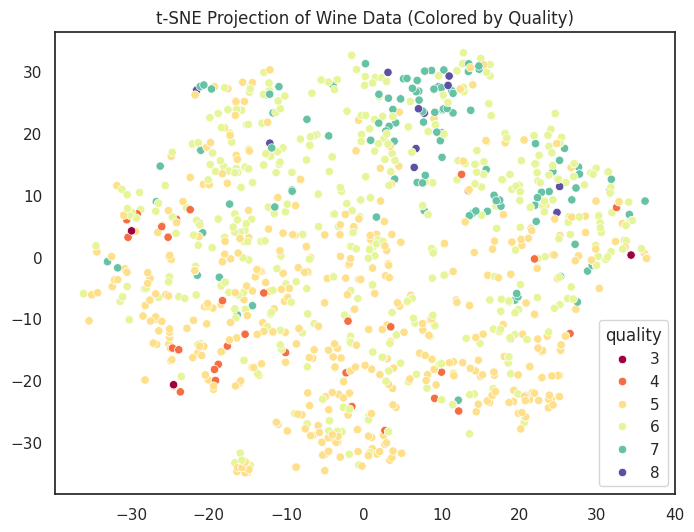

DBSCAN found 39 clusters and 341 noise points.


In [ ]:
# --- Visualize t-SNE projection before clustering ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=y,
    palette='Spectral',
    legend='full'
)
plt.title('t-SNE Projection of Wine Data (Colored by Quality)')
plt.show()

# --- Apply DBSCAN clustering on t-SNE features ---
db = DBSCAN(eps=2.5, min_samples=10)
db.fit(X_embedded)

labels = db.labels_
n_clusters = len(set(labels) - {-1})
n_noise = list(labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")

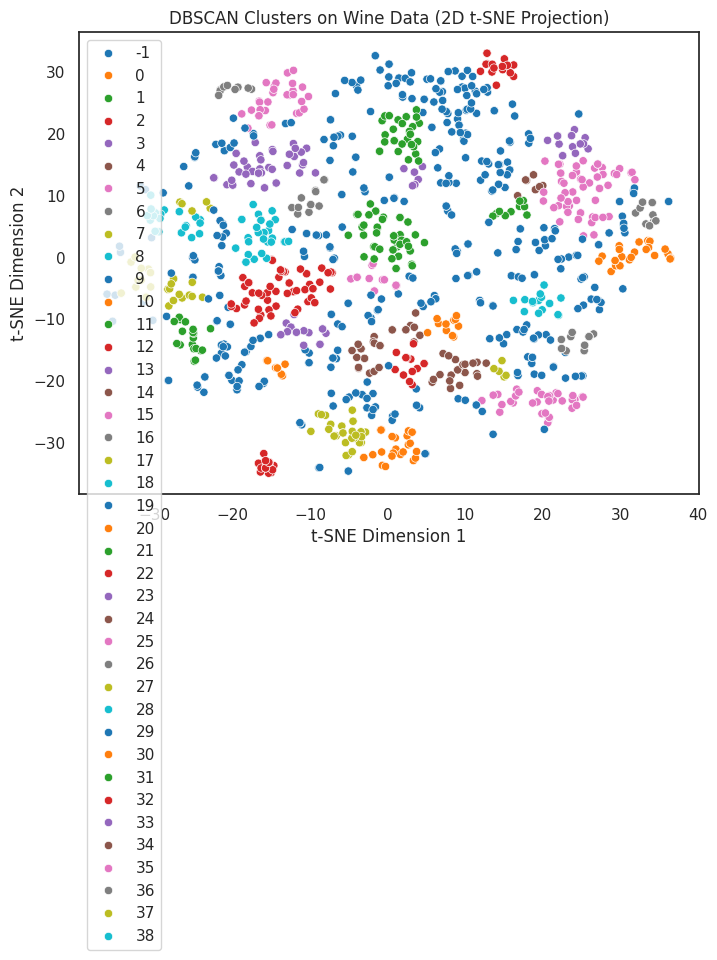

In [ ]:
# --- Add cluster labels to the DataFrame ---
df['Cluster'] = labels  # lengths now match exactly

# --- Visualize clusters detected by DBSCAN ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=labels,
    palette='tab10',
    legend='full'
)
plt.title('DBSCAN Clusters on Wine Data (2D t-SNE Projection)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
# --- Show average wine quality per cluster ---
if n_clusters > 0:
    cluster_quality = df.groupby('Cluster')['quality'].mean().sort_values()
    print("\nAverage wine quality by cluster:")
    print(cluster_quality)


Average wine quality by cluster:
Cluster
 11    4.900000
 6     5.000000
 27    5.000000
 28    5.090909
 0     5.160000
 14    5.176471
 24    5.200000
 9     5.230769
 4     5.238095
 38    5.250000
 5     5.270270
 7     5.300000
 12    5.333333
 23    5.375000
 25    5.384615
 10    5.461538
 2     5.482759
 17    5.486486
 30    5.500000
 1     5.500000
 20    5.500000
 22    5.538462
-1     5.548387
 33    5.625000
 8     5.676471
 26    5.692308
 37    5.800000
 35    5.806452
 13    5.829787
 36    5.928571
 29    5.937500
 3     6.000000
 18    6.000000
 34    6.142857
 32    6.176471
 31    6.193548
 16    6.200000
 15    6.254545
 21    6.636364
 19    6.690909
Name: quality, dtype: float64


In [ ]:
# --- Cluster analysis: compare DBSCAN clusters with true labels ---
print("\nCluster-to-Label Relationship:")

for cluster_label in set(db.labels_):
    print('-' * 40)
    if cluster_label == -1:
        print(f"Cluster {cluster_label}: Noise points")
        continue

    mask = db.labels_ == cluster_label
    cluster_y = y[mask]

    if len(cluster_y) == 0:
        print(f"Cluster {cluster_label}: Empty?")
        continue

    unique, counts = np.unique(cluster_y, return_counts=True)
    dominant_class = unique[np.argmax(counts)]
    ratio = counts.max() / counts.sum()

    print(f"Cluster #{cluster_label}")
    print(f"  → Total samples: {len(cluster_y)}")
    print(f"  → Dominant true class: {dominant_class} ({ratio * 100:.1f}% of cluster)")
    print(f"  → Class breakdown: {dict(zip(unique, counts))}")



Cluster-to-Label Relationship:
----------------------------------------
Cluster #0
  → Total samples: 25
  → Dominant true class: 5 (76.0% of cluster)
  → Class breakdown: {np.int64(4): np.int64(1), np.int64(5): np.int64(19), np.int64(6): np.int64(5)}
----------------------------------------
Cluster #1
  → Total samples: 48
  → Dominant true class: 5 (50.0% of cluster)
  → Class breakdown: {np.int64(4): np.int64(1), np.int64(5): np.int64(24), np.int64(6): np.int64(21), np.int64(7): np.int64(2)}
----------------------------------------
Cluster #2
  → Total samples: 58
  → Dominant true class: 5 (51.7% of cluster)
  → Class breakdown: {np.int64(4): np.int64(2), np.int64(5): np.int64(30), np.int64(6): np.int64(22), np.int64(7): np.int64(4)}
----------------------------------------
Cluster #3
  → Total samples: 16
  → Dominant true class: 6 (75.0% of cluster)
  → Class breakdown: {np.int64(5): np.int64(2), np.int64(6): np.int64(12), np.int64(7): np.int64(2)}
------------------------------

In [ ]:
# --- Analyze DBSCAN clustering results ---

# Count clusters (exclude noise = -1)
n_clusters = len(set(labels) - {-1})

# Count noise points
n_noise = list(labels).count(-1)

print("=== DBSCAN Cluster Summary ===")
print(f"Total data points: {len(labels)}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print("\nCluster size summary:")

# Display number of points in each cluster
unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    if u == -1:
        print(f"  Cluster {u} (Noise): {c} samples")
    else:
        print(f"  Cluster {u}: {c} samples")

=== DBSCAN Cluster Summary ===
Total data points: 1194
Number of clusters found: 39
Number of noise points: 341

Cluster size summary:
  Cluster -1 (Noise): 341 samples
  Cluster 0: 25 samples
  Cluster 1: 48 samples
  Cluster 2: 58 samples
  Cluster 3: 16 samples
  Cluster 4: 21 samples
  Cluster 5: 37 samples
  Cluster 6: 14 samples
  Cluster 7: 30 samples
  Cluster 8: 34 samples
  Cluster 9: 13 samples
  Cluster 10: 13 samples
  Cluster 11: 20 samples
  Cluster 12: 15 samples
  Cluster 13: 47 samples
  Cluster 14: 17 samples
  Cluster 15: 55 samples
  Cluster 16: 10 samples
  Cluster 17: 37 samples
  Cluster 18: 16 samples
  Cluster 19: 55 samples
  Cluster 20: 28 samples
  Cluster 21: 11 samples
  Cluster 22: 13 samples
  Cluster 23: 16 samples
  Cluster 24: 10 samples
  Cluster 25: 13 samples
  Cluster 26: 13 samples
  Cluster 27: 6 samples
  Cluster 28: 11 samples
  Cluster 29: 16 samples
  Cluster 30: 10 samples
  Cluster 31: 31 samples
  Cluster 32: 17 samples
  Cluster 33: 8 s

853 wines (≈ 71%) were clustered

341 wines (≈ 29%) were treated as noise (outliers).

## 4. Regression

### Linear & Ridge Regression

In [ ]:
#Regression path
#Predict the alcohol percentage of wine based on its other chemical properties

# Select features (X) and target (y) for regression
X_reg = df.drop('alcohol', axis=1)
y_reg = df['alcohol']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression:")
print("  RMSE:", rmse_lr)
print("  R2:", r2_score(y_test, y_pred_lr))


Linear Regression:
  RMSE: 0.46595317646125817
  R2: 0.7860519295436084


## 5. Classification


### Train/Test Split & Scaling


### SVM & Random Forest

In [ ]:
#Classification path


# Create binary target
df['is_good_wine'] = (df['quality'] >= 7).astype(int)

X_clf = df.drop(['quality', 'is_good_wine', 'Cluster'], axis=1, errors='ignore')
y_clf = df['is_good_wine']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Apply SMOTE only on the training set
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# SVM Classifier
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Classification:")
print("  Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classification:")
print("  Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


SVM Classification:
  Accuracy: 0.891213389121339
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       212
           1       0.53      0.37      0.43        27

    accuracy                           0.89       239
   macro avg       0.72      0.66      0.69       239
weighted avg       0.88      0.89      0.88       239

Random Forest Classification:
  Accuracy: 0.9246861924686193
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       212
           1       0.70      0.59      0.64        27

    accuracy                           0.92       239
   macro avg       0.82      0.78      0.80       239
weighted avg       0.92      0.92      0.92       239

